### SweetWater Reimplementation

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/MyDrive/INF-8225')
os.getcwd()

print("Contents:")
print(os.listdir('.'))

print("data/ folder contents:")
print(os.listdir('./data'))

Mounted at /content/drive
Contents:
['data', 'grid_mse_phases.png', 'results_summary.csv', 'heatmap_model_3_c1_4_c2_8_es_True_[50, 50, 100].png', 'heatmap_model_0_c1_2_c2_4_es_True_[50, 50, 100].png', 'heatmap_model_1_c1_2_c2_4_es_True_[10, 10, 50].png', 'heatmap_model_2_c1_2_c2_4_es_False_[0, 0, 0].png', 'heatmap_model_4_c1_4_c2_8_es_True_[10, 10, 50].png', 'heatmap_model_5_c1_4_c2_8_es_False_[0, 0, 0].png', 'heatmap_model_6_c1_6_c2_12_es_True_[50, 50, 100].png', 'heatmap_model_8_c1_6_c2_12_es_False_[0, 0, 0].png', 'heatmap_model_7_c1_6_c2_12_es_True_[10, 10, 50].png']
data/ folder contents:
['human_liver.tsv', 'scrna_reduced_3000.tsv', 'bulkrna_reduced_3000.tsv', 'output', 'bulkrna_reduced_3000.gsheet']


## Python package à installer

In [ ]:
!pip install git+https://github.com/DingWB/PyComplexHeatmap
!pip install captum





  Cloning https://github.com/DingWB/PyComplexHeatmap to /tmp/pip-req-build-wnz2f7z2
  Running command git clone --filter=blob:none --quiet https://github.com/DingWB/PyComplexHeatmap /tmp/pip-req-build-wnz2f7z2
  Resolved https://github.com/DingWB/PyComplexHeatmap to commit f5b58f654b314812a79b4be01e664da462e05cda
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.2 MB/s eta 0:00:00
  Created wheel for PyComplexHeatmap: filename=pycomplexheatmap-1.8.2.post7-py3-none-any.whl size=65706 sha256=c9e34e9d66c68a29474c3ed8c6a6118bb4c06864f43530146a04aa67a2002f7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bpchdhtt/wheels/7a/6b/53/3e5698617bc244d5d9a85d25523ab533026750c7d23deb386a
Successfully built PyComplexHeatmap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4

## Voici les différents import qu'on a besoin dans le projet

In [ ]:
import torch
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from captum.attr import DeepLift
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import combinations
from tqdm import tqdm
from scipy import stats
from functools import reduce as red
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.io import mmread
from collections import Counter, defaultdict
import PyComplexHeatmap as pych
from torch.nn import Linear, ReLU, Sigmoid, Dropout, Softmax, GELU
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.patches as mpatches

##Preprocess les données  
On a pris les preprocess de data de leur github pour pouvoir bien tester les données. Il y a le generate_synthetic qui permet de sortir les y associés:  

- build_dfdict(scRNA) : crée un dict {celltype_id: [indices des cellules]} à partir de l’index de scRNA.

- generate_fractions_dirichlet(samples, nct) : génère toutes les combinaisons de proportions de nct types cellulaires via des tirages Dirichlet.

- gen_expr(x, props, dfd, ncells) : simule l’expression bulk en échantillonnant ncells cellules par type selon les proportions et en sommant leurs profils.

- generate_synthethic(scRNA, nsamples, ct) : enchaîne build_dfdict, generate_fractions_dirichlet et gen_expr pour produire xpseudo, ypseudo.

- convert_to_float_tensors(*args) : convertit des arrays NumPy en tenseurs PyTorch float.

- transform_and_normalize(*args) : applique log2+1 puis MinMaxScaler (0–1) en transposant pour conserver l’ordre des gènes.

In [ ]:
#get the dictionary of positions
def build_dfdict(scRNA):

    cells = scRNA.index.tolist()
    ctdict = {x:i for i, x in enumerate(sorted(set(scRNA.index)))}
    dfdict = {}
    for i, ct in enumerate(cells):
        if ctdict[ct] in dfdict:
            dfdict[ctdict[ct]].append(i)
        else:
            dfdict[ctdict[ct]] = [i]

    return dfdict

#generate the fractions using the dirichlet distribution and combining celltypes
def generate_fractions_dirichlet(samples, nct):

    #generate random positions vector
    combl = []
    ncombl = sum(map(len,[list(combinations(range(nct),i)) for i in range(1,nct+1)]))
    l = m.ceil(samples/ncombl)

    for i in range(1, nct+1): ## group of combinations
        cmb = list(combinations(range(nct),i))
        for e in cmb:
            combelm = np.zeros((l, nct))
            combelm[:,e] = np.random.dirichlet(alpha = np.ones(len(e)), size = l)
            combl.append(combelm)


    mat = np.vstack(combl)
    assert np.sum(mat.sum(axis=1)) == mat.shape[0]

    return mat

def gen_expr(x, props, dfd, ncells):

    #get the percentage of each celltype
    props_int = np.int32(props * ncells[:,None])

    #set to 0 if not sampled
    props[props_int == 0] = 0
    props = (props.T/props.sum(axis=1)).T

    #init empty list
    samples_l = []

    for i in tqdm(range(props.shape[0]), desc = 'simulating bulk'):

        sample_l = [x[np.random.choice(dfd[k], size=s)] for k,s in enumerate(props_int[i,:]) if s > 0]
        sample_v = np.vstack(sample_l).sum(axis=0)
        samples_l.append(sample_v)

    samples_v = np.vstack(samples_l)

    return samples_v, props

def generate_synthethic(scRNA, nsamples = 1000, ct=None):

    #get the celltype
    if ct:
       celltypes = ct
    else:
        celltypes = sorted(set(scRNA.index))

    #build dfdict
    dfd = build_dfdict(scRNA)

    #transform to a faster datatype
    scRNA = np.ascontiguousarray(scRNA.values, dtype=np.float32)

    """
    Generate fractions
    """

    #generate proportions
    props = generate_fractions_dirichlet(samples = nsamples, nct = len(celltypes))

    """
    Generate expression for train/test distribution
    """

    #define ncells
    ncells = np.random.randint(100, max(101, scRNA.shape[0]//10), props.shape[0]) ## from 100 to scRNA.shape[0]//10 ncells

    #generate expression for training/test distribution
    xpseudo, ypseudo = gen_expr(x = scRNA, props = props, dfd = dfd, ncells = ncells)

    return xpseudo, ypseudo, celltypes

def convert_to_float_tensors(*args):
    return [torch.tensor(x).float() for x in args]

def transform_and_normalize(*args):
    return [MinMaxScaler(feature_range=(0,1)).fit_transform(np.log2(x+1).T).T for x in args]

## Autres fonctions

In [ ]:
def CCCscore(y_pred, y_true, mode='all'):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # pred: shape{n sample, m cell}
    if mode == 'all':
        y_pred = y_pred.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)

    elif mode == 'avg':
        pass

    ccc_value = 0

    for i in range(y_pred.shape[1]):

        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        ccc_value += ccc

    return ccc_value / y_pred.shape[1]

def plot_complexheatmap(df, marker_annot, save_path, title):
    # Normalize
    df = df / df.max()

    # Create color map
    unique_cts = marker_annot["celltype"].unique()
    colors = plt.cm.tab10.colors[:len(unique_cts)]
    color_map = dict(zip(unique_cts, colors))
    marker_annot["color"] = marker_annot["celltype"].map(color_map)

    # Create row annotations
    row_ha = pych.HeatmapAnnotation(
        ct=pych.anno_simple(marker_annot["celltype"], colors=color_map, add_text=True, legend=False, height=6),
        axis=0,
        verbose=0
    )


    # Draw heatmap
    plt.figure(figsize=(12, 10))
    cm = pych.ClusterMapPlotter(
        data=df,
        col_cluster=False,
        row_cluster=False,
        cmap="viridis",
        left_annotation=row_ha,
        row_names_side='right',
        col_names_side='top',
        show_rownames=True,
        show_colnames=True,
        row_dendrogram=False,
        label='DeepLift Score',
        xticklabels_kws={'labelrotation': 45, 'labelsize': 12},
        yticklabels_kws={'labelsize': 8},
        rasterized=False
    )

    # Manually add the legend
    handles = [mpatches.Patch(color=color_map[ct], label=ct) for ct in unique_cts]
    plt.legend(handles=handles, title="Cell Type", bbox_to_anchor=(-1, -0.5), loc="center left", fontsize=10, title_fontsize=12)

    fig = plt.gcf()
    axes = fig.axes
    colorbar_ax = axes[-1]
    colorbar_ax.set_position((1.05, 0.7, 0.01, 0.2))
    plt.suptitle(title, fontsize=18, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()



## EarlyStopper
Dans leur code, il utilise un early stopper qui permet d'arrêter d'essayer de trouver un nouveau modèle meilleur lorsqu'après x itération, qui représente la patience, l'accuracy loss ne s'est pas amélioré. Donc, dans chacune des phases, on appelle la fonction early stop pour arrêté le modèle après une certaine valeur. Ceci permet en quelque sorte de ne pas avoir d'overfitting.

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        print(f"Stablishing Early Stopping with patience {patience}")

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Encoder-Decoder Custom

In [ ]:
class SweetWaterAutoEncoder(torch.nn.Module):
    def __init__(self, num_features, num_classes, compress_length1, compress_length2, isRelu = True):

        self.num_features = num_features
        self.num_classes = num_classes

        self.bigger_width = int(self.num_features//compress_length1)
        self.smaller_width = int(self.num_features//compress_length2)
        self.isRelu = isRelu
        super().__init__()
        torch.manual_seed(418)

        #encoder_layer
        self.first_layer_encoder = Linear(self.num_features, self.bigger_width)
        self.second_layer_encoder = Linear(self.bigger_width, self.smaller_width)

        #decoder_layer
        self.first_layer_decoder = Linear(self.smaller_width, self.bigger_width)
        self.second_layer_decoder = Linear(self.bigger_width, self.num_features)

        #prop layers
        self.propl1 = Linear(self.smaller_width, self.smaller_width)
        self.propl2 = Linear(self.smaller_width, self.num_classes)

        #activation functions
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()

        self.gelu1 = GELU()
        self.gelu2 = GELU()
        self.gelu3 = GELU()
        self.softmax = Softmax(dim=1)

    def forward(self, x, mode = 'phase3'):

        ## encoder
        first_encoder = self.first_layer_encoder(x)
        if self.isRelu:
            activation_encoder = self.relu1(first_encoder)
        else:
            activation_encoder = self.gelu1(first_encoder)
        second_encoder = self.second_layer_encoder(activation_encoder)

        if mode == 'phase3':

            ##proportions inference
            propl1 = self.propl1(second_encoder)
            if self.isRelu:
                propl1 = self.relu3(propl1)
            else:
                propl1 = self.gelu3(propl1)
            propl2 = self.propl2(propl1)
            propl2 = self.softmax(propl2)

            return propl2

        else:

            ##decoder
            first_decoder = self.first_layer_decoder(second_encoder)
            if self.isRelu:
                activation_decoder = self.relu2(first_decoder)
            else:
                activation_decoder = self.gelu2(first_decoder)
            second_decoder = self.second_layer_decoder(activation_decoder)

            return second_decoder

## Classe SweetWater

In [ ]:
class SweetWater:

    def __init__(self, data, bulkrna, name, batch_size = 128, epochs = 1000, lr = 0.01, patience_tree = [10, 10, 50], earlystopping=True, compress_length1 = 2, compress_length2 = 4, isRelu = True):

        self.xtrain, self.ytrain, self.xtest, self.ytest = data
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        """
        Bulkrna
        """

        #define train/test sets just to trigger earlystop if phase2 overfits
        self.bulk_train, self.bulk_test = train_test_split(bulkrna, test_size = 0.2, random_state=13)
        self.bulk_train = self.bulk_train.float()
        self.bulk_test = self.bulk_test.float().to(self.device)

        """
        Define parameters
        """

        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.earlystopping = earlystopping
        if self.earlystopping:
            self.p1es = EarlyStopper(patience_tree[0])
            self.p2es = EarlyStopper(patience_tree[1])
            self.p3es = EarlyStopper(patience_tree[2])
        self.name = name

        # ajout du tracking des MSE pour chaque phase
        self.p1_train_mse_history, self.p1_test_mse_history = [], []
        self.p2_train_mse_history, self.p2_test_mse_history = [], []
        self.p3_train_mse_history, self.p3_test_mse_history = [], []
        self.p3_train_r2_history, self.p3_test_r2_history = [], []
        self.compress_length1 = compress_length1
        self.compress_length2 = compress_length2
        self.isRelu = isRelu
        self.setup()

    def setup(self):

        #model and metrics
        self.aemodel = SweetWaterAutoEncoder(
            num_features = self.xtrain.shape[1],
            num_classes = self.ytrain.shape[1],
            compress_length1=self.compress_length1,
            compress_length2=self.compress_length2,
            isRelu = self.isRelu
            ).to(self.device)
        self.mseloss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.aemodel.parameters(), lr = self.lr)

        ## Phase 1: Pseudobulk Alignment
        self.phase1_dl = DataLoader(self.xtrain, batch_size = self.batch_size, shuffle = True)
        self.phase1_dl_test = DataLoader(self.xtest, batch_size = self.batch_size, shuffle = True)

        ## Phase 2: Bulk Alignment
        self.phase2_dl = DataLoader(self.bulk_train, batch_size = 1, shuffle = True)

        ## Phase 3: Pseudobulk proportions deconvolution
        self.phase3_ds = TensorDataset(self.xtrain, self.ytrain)
        self.phase3_dl = DataLoader(self.phase3_ds, batch_size = self.batch_size, shuffle = True)
        self.phase3_ds_test = TensorDataset(self.xtest, self.ytest)
        self.phase3_dl_test = DataLoader(self.phase3_ds_test, batch_size = self.batch_size, shuffle = True)

        #define r2 metric
        self.r2 = lambda true, pred : 1 - ((np.square((true - pred)).mean()) / (np.square(true - true.mean(axis=0))).mean())

    def train(self, x, ytrue=None, mode='phase1'):

        self.optimizer.zero_grad()  # Clear gradients.
        if mode != 'phase3': #phase1 or phase 2

            xhat = self.aemodel(x, mode)  # Perform a single forward pass.
            aeloss = self.mseloss(x, xhat)
            loss = aeloss

        else:

            yhat = self.aemodel(x, mode)
            proploss = self.mseloss(ytrue, yhat)
            loss = proploss

        loss.backward()  # Derive gradients.
        self.optimizer.step()  # Update parameters based on gradients.

        if mode != 'phase3':
            return loss.detach().__float__()
        else:
            return loss.detach().__float__(), yhat

    @torch.no_grad()
    def test(self, x, ytrue=None, mode='phase1'):

        if mode != 'phase3': #phase1 or phase 2
            xhat = self.aemodel(x, mode)  # Perform a single forward pass.
            aeloss = self.mseloss(x, xhat)
            loss = aeloss
        else:
            yhat = self.aemodel(x, mode)
            proploss = self.mseloss(ytrue, yhat)
            loss = proploss

        if mode != 'phase3':
            return loss.detach().__float__()
        else:
            return loss.detach().__float__(), yhat

    def run_phase1(self):
        with tqdm(total = int(self.epochs), mininterval=10) as pbar:

            for _ in range(int(self.epochs)):

                btrloss, bteloss = [], []

                for xpseudo in self.phase1_dl:

                    batch_pseudo_alignment_loss = self.train(x = xpseudo.to(self.device), mode='phase1')
                    btrloss.append(batch_pseudo_alignment_loss)

                for xpseudo_test in self.phase1_dl_test:
                    bteloss.append(self.test(x = xpseudo_test.to(self.device), mode='phase1'))

                test_pseudo_alignment_loss = np.mean(bteloss)

                self.p1_train_mse_history.append(np.mean(btrloss))
                self.p1_test_mse_history.append(test_pseudo_alignment_loss)

                ## early stopping condition
                if self.earlystopping:
                    if self.p1es.early_stop(self.p1_test_mse_history[-1]):
                        print("Early stopping condition achieved")
                        break

                pbar.set_description(f'P1: Train MSE is: {round(self.p1_train_mse_history[-1],6)}, Test MSE is {round(self.p1_test_mse_history[-1],6)}', refresh=False)
                pbar.update(1)

    def run_phase2(self):
        with tqdm(total = self.epochs, mininterval=10) as pbar:

            for _ in range(self.epochs):

                btrloss = []

                for xbulk in self.phase2_dl:

                    batch_pseudo_alignment_loss = self.train(x = xbulk.to(self.device), mode='phase2')
                    btrloss.append(batch_pseudo_alignment_loss)

                self.p2_train_mse_history.append(np.mean(btrloss))
                self.p2_test_mse_history.append(self.test(self.bulk_test, mode='phase2'))

                ## early stopping condition
                if self.earlystopping:
                    if self.p2es.early_stop(self.p2_test_mse_history[-1]):
                        print("Early stopping condition achieved")
                        break

                pbar.set_description(f'P2: Train MSE is: {round(self.p2_train_mse_history[-1],6)}, Test MSE is: {round(self.p2_test_mse_history[-1],6)}', refresh=False)
                pbar.update(1)

    def run_phase3(self):
        with tqdm(total = self.epochs, mininterval=10) as pbar:
            for _ in range(self.epochs):

                batched_trproploss, batched_trpropr2 = [], []

                ## train
                for xpseudo, bypseudo in self.phase3_dl:

                    bproploss, bypred = self.train(x = xpseudo.to(self.device), ytrue = bypseudo.to(self.device), mode='phase3')
                    batched_trproploss.append(bproploss)

                    bpropr2 = self.r2(bypseudo.numpy(), bypred.cpu().detach().numpy())
                    batched_trpropr2.append(bpropr2)

                self.p3_train_mse_history.append(np.mean(batched_trproploss))
                self.p3_train_r2_history.append(np.mean(batched_trpropr2))

                btestproploss, btestr2 = [], []
                for xpseudo_test, bypseudo_test in self.phase3_dl_test:
                    ## test
                    testproploss_, testypred = self.test(xpseudo_test.to(self.device), bypseudo_test.to(self.device), mode='phase3')

                    btestproploss.append(testproploss_)
                    btestr2.append(self.r2(bypseudo_test.numpy(), testypred.cpu().detach().numpy()))

                self.p3_test_mse_history.append(np.mean(btestproploss))
                self.p3_test_r2_history.append(np.mean(btestr2))

                ## early stopping condition
                if self.earlystopping:
                    if self.p3es.early_stop(self.p3_test_mse_history[-1]):
                        print("\n","Early stopping condition achieved")
                        break

                pbar.set_description(f'P3: Train MSE {round(self.p3_train_mse_history[-1],6)}, test MSE {round(self.p3_test_mse_history[-1],6)}, Train R2 {round(self.p3_train_r2_history[-1],4)}, Test R2 {round(self.p3_test_r2_history[-1],4)}', refresh=False)
                pbar.update(1)

    def run(self):
        ## freeze layers from proportions deconvolution
        for name, param in self.aemodel.named_parameters():
            if 'prop' in name:
                param.requires_grad = False

        #run pseudobulk alignment and reset early stopping
        self.run_phase1()

        #now run proportions alignment
        self.run_phase2()

        ### freeze layers from the decoder
        for name, param in self.aemodel.named_parameters():
            if 'decl' in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        #run bulk alignment and reset early stopping
        self.run_phase3()

## conversion des données pour fit avec le modèle

In [ ]:
# Set manual parameters
scrna_path = './data/scrna_reduced_3000.tsv'
bulkrna_path = './data/bulkrna_reduced_3000.tsv'
datasetname = 'example'
nsamples = 5000
OUTPUT_PATH = './data/output/'
train_size = 0.8
test_size = 0.2


# Load data
scRNA = pd.read_csv(scrna_path, sep='\t', index_col=0)
bulkRNA = pd.read_csv(bulkrna_path, sep='\t', index_col=0)

# Split into train and test
print("Splitting data into train and test sets.")
scRNA_train, scRNA_test = train_test_split(scRNA.copy(), stratify=scRNA.index, test_size=test_size, random_state=42)

# Create pseudobulk for train and test
xtrain, ytrain, celltypes = generate_synthethic(scRNA_train, nsamples=int(nsamples * train_size))
xtest, ytest, _ = generate_synthethic(scRNA_test, nsamples=int(nsamples * test_size))

# Transform and normalize
xtrain, xtest, xbulk = transform_and_normalize(xtrain, xtest, bulkRNA.values)

# Convert to torch tensors
xtrain, ytrain, xtest, ytest, xbulk = convert_to_float_tensors(xtrain, ytrain, xtest, ytest, xbulk)



Splitting data into train and test sets.


simulating bulk: 100%|██████████| 1023/1023 [00:00<00:00, 1733.23it/s]


## Test de différents modèles

In [ ]:
best_model = None
best_r2 = -float("inf")
best_model_path = ""
batch_size = 256
best_compress1 = 0
best_compress2 = 0
experiments_data = []

for compress1, compress2 in [(2, 4), (4, 8), (6, 12)]:
    for earlystop in [True, False]:
        if earlystop:
            patience_list = [[50, 50, 100], [10, 10, 50]]
        else:
            patience_list = [[0, 0, 0]]

        for patience_tree in patience_list:
            print(f"Running with compress1={compress1}, compress2={compress2}, earlystop={earlystop}, patience={patience_tree}")

            # Init model
            epochs = round(30000 / (xtrain.shape[0] / batch_size))
            sw = SweetWater(data=(xtrain, ytrain, xtest, ytest),
                            bulkrna=xbulk,
                            name=datasetname,
                            lr=1e-5, batch_size=batch_size, epochs=epochs,
                            patience_tree=patience_tree, earlystopping=earlystop,
                            compress_length1=compress1, compress_length2=compress2)

            # Train
            start_time = time.time()
            sw.run()
            end_time = time.time()
            elapsed_time = round(end_time - start_time, 2)

            # Store experiment
            experiments_data.append({
                "config": {
                    "compress1": compress1,
                    "compress2": compress2,
                    "patience": patience_tree,
                    "earlystop": earlystop,
                    "isRelu": True
                },
                "time": elapsed_time,
                "model": sw.aemodel.state_dict(),
                "p1_train_mse": sw.p1_train_mse_history,
                "p1_test_mse": sw.p1_test_mse_history,
                "p2_train_mse": sw.p2_train_mse_history,
                "p2_test_mse": sw.p2_test_mse_history,
                "p3_train_mse": sw.p3_train_mse_history,
                "p3_test_mse": sw.p3_test_mse_history,
                "p3_train_r2": sw.p3_train_r2_history,
                "p3_test_r2": sw.p3_test_r2_history,
                "final_r2": sw.p3_test_r2_history[-1]
            })

            # Update best model
            if final_r2 > best_r2:
                best_r2 = final_r2
                best_model = sw.aemodel.state_dict()
                best_model_path = os.path.join(OUTPUT_PATH, f'best_model_r2.pt')
                best_compress1 = compress1
                best_compress2 = compress2


# Save the best one
os.makedirs(OUTPUT_PATH, exist_ok=True)
torch.save(best_model, best_model_path)
print(f"Best model saved at: {best_model_path}")



Running with compress1=2, compress2=4, earlystop=True, patience=[50, 50, 100]
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 100


P1: Train MSE is: 0.000308, Test MSE is 0.001321: 100%|██████████| 1906/1906 [05:13<00:00,  6.07it/s]
P2: Train MSE is: 0.000108, Test MSE is: 0.000403:  23%|██▎       | 438/1906 [01:28<04:57,  4.94it/s]


Early stopping condition achieved


P3: Train MSE 0.000228, test MSE 0.001083, Train R2 0.9972, Test R2 0.987:  31%|███▏      | 599/1906 [01:19<02:53,  7.53it/s] 



 Early stopping condition achieved
Running with compress1=2, compress2=4, earlystop=True, patience=[10, 10, 50]
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 50


P1: Train MSE is: 0.000351, Test MSE is 0.001373:  21%|██▏       | 409/1906 [01:06<04:01,  6.19it/s]


Early stopping condition achieved


P2: Train MSE is: 0.000308, Test MSE is: 0.000503:   9%|▊         | 165/1906 [00:33<05:50,  4.97it/s]


Early stopping condition achieved


P3: Train MSE 0.000229, test MSE 0.001151, Train R2 0.9972, Test R2 0.9862:  34%|███▍      | 657/1906 [01:25<02:43,  7.65it/s]



 Early stopping condition achieved
Running with compress1=2, compress2=4, earlystop=False, patience=[0, 0, 0]


P2: Train MSE is: 2e-06, Test MSE is: 0.000419: 100%|██████████| 1906/1906 [06:22<00:00,  4.98it/s]
P3: Train MSE 8.5e-05, test MSE 0.001441, Train R2 0.999, Test R2 0.9826: 100%|██████████| 1906/1906 [04:04<00:00,  7.81it/s]


Running with compress1=4, compress2=8, earlystop=True, patience=[50, 50, 100]
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 100


P1: Train MSE is: 0.000324, Test MSE is 0.001342:  99%|█████████▉| 1891/1906 [03:09<00:01, 10.00it/s]


Early stopping condition achieved


P2: Train MSE is: 0.00011, Test MSE is: 0.00039:  47%|████▋     | 892/1906 [01:53<02:08,  7.86it/s]  


Early stopping condition achieved


P3: Train MSE 0.000309, test MSE 0.001028, Train R2 0.9962, Test R2 0.9876:  41%|████▏     | 787/1906 [01:25<02:01,  9.23it/s]



 Early stopping condition achieved
Running with compress1=4, compress2=8, earlystop=True, patience=[10, 10, 50]
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 50


P1: Train MSE is: 0.000346, Test MSE is 0.001365:  42%|████▏     | 810/1906 [01:19<01:48, 10.15it/s]


Early stopping condition achieved


P2: Train MSE is: 0.000444, Test MSE is: 0.00065:   5%|▌         | 97/1906 [00:12<03:48,  7.91it/s] 


Early stopping condition achieved


P3: Train MSE 0.000327, test MSE 0.001163, Train R2 0.996, Test R2 0.986:  38%|███▊      | 728/1906 [01:19<02:08,  9.14it/s]  



 Early stopping condition achieved
Running with compress1=4, compress2=8, earlystop=False, patience=[0, 0, 0]


P2: Train MSE is: 1.4e-05, Test MSE is: 0.000421: 100%|██████████| 1906/1906 [04:16<00:00,  7.43it/s]
P3: Train MSE 0.000117, test MSE 0.001202, Train R2 0.9986, Test R2 0.9856: 100%|██████████| 1906/1906 [03:27<00:00,  9.17it/s]


Running with compress1=6, compress2=12, earlystop=True, patience=[50, 50, 100]
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 100


P1: Train MSE is: 0.000332, Test MSE is 0.00135:  90%|████████▉ | 1706/1906 [02:23<00:16, 11.91it/s]


Early stopping condition achieved


P2: Train MSE is: 0.000136, Test MSE is: 0.000403:  61%|██████    | 1164/1906 [01:59<01:15,  9.78it/s]


Early stopping condition achieved


P3: Train MSE 0.000285, test MSE 0.000961, Train R2 0.9965, Test R2 0.9884:  55%|█████▌    | 1049/1906 [01:50<01:30,  9.51it/s]



 Early stopping condition achieved
Running with compress1=6, compress2=12, earlystop=True, patience=[10, 10, 50]
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 50


P1: Train MSE is: 0.000375, Test MSE is 0.001402:  38%|███▊      | 733/1906 [01:01<01:37, 11.99it/s]


Early stopping condition achieved


P2: Train MSE is: 0.000504, Test MSE is: 0.000766:   3%|▎         | 64/1906 [00:06<03:13,  9.54it/s]


Early stopping condition achieved


P3: Train MSE 0.000501, test MSE 0.001187, Train R2 0.9939, Test R2 0.9857:  42%|████▏     | 802/1906 [01:24<01:56,  9.47it/s]



 Early stopping condition achieved
Running with compress1=6, compress2=12, earlystop=False, patience=[0, 0, 0]


P2: Train MSE is: 6.1e-05, Test MSE is: 0.000398: 100%|██████████| 1906/1906 [03:14<00:00,  9.80it/s]
P3: Train MSE 0.000161, test MSE 0.001082, Train R2 0.998, Test R2 0.987: 100%|██████████| 1906/1906 [03:20<00:00,  9.51it/s] 

Best model saved at: ./data/output/best_model_r2.pt


## Test du modèle avec une fonction d'activation GeLU au lieu de ReLU

In [ ]:
batch_size = 256
epochs = round(30000 / (xtrain.shape[0] / batch_size))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
patience_list = [[50, 50, 100], [10, 10, 50]]

for patience_tree in patience_list:
    sw = SweetWater(data=(xtrain, ytrain, xtest, ytest),
                    bulkrna=xbulk,
                    name=datasetname,
                    lr=1e-5, batch_size=batch_size, epochs=epochs,
                    patience_tree=patience_tree, earlystopping=True,
                    compress_length1=2, compress_length2=4, isRelu=False)

    start_time = time.time()
    sw.run()
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 2)

    # Store experiment
    experiments_data.append({
        "config": {
            "compress1": 2,
            "compress2": 4,
            "patience": patience_tree,
            "earlystop": True,
            "isRelu": False
        },
        "time": elapsed_time,
        "model": sw.aemodel.state_dict(),
        "p1_train_mse": sw.p1_train_mse_history,
        "p1_test_mse": sw.p1_test_mse_history,
        "p2_train_mse": sw.p2_train_mse_history,
        "p2_test_mse": sw.p2_test_mse_history,
        "p3_train_mse": sw.p3_train_mse_history,
        "p3_test_mse": sw.p3_test_mse_history,
        "p3_train_r2": sw.p3_train_r2_history,
        "p3_test_r2": sw.p3_test_r2_history,
        "final_r2": sw.p3_test_r2_history[-1]
    })




Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 50
Stablishing Early Stopping with patience 100


P1: Train MSE is: 0.000306, Test MSE is 0.001311: 100%|██████████| 1906/1906 [05:06<00:00,  6.23it/s]
P2: Train MSE is: 8.8e-05, Test MSE is: 0.000363:  32%|███▏      | 607/1906 [02:00<04:16,  5.06it/s]


Early stopping condition achieved


P3: Train MSE 0.000188, test MSE 0.000921, Train R2 0.9977, Test R2 0.9889:  38%|███▊      | 731/1906 [01:33<02:30,  7.81it/s]



 Early stopping condition achieved
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 10
Stablishing Early Stopping with patience 50


P1: Train MSE is: 0.000437, Test MSE is 0.001472:  11%|█         | 211/1906 [00:33<04:32,  6.23it/s]


Early stopping condition achieved


P2: Train MSE is: 0.000293, Test MSE is: 0.000473:  11%|█         | 206/1906 [00:41<05:38,  5.02it/s]


Early stopping condition achieved


P3: Train MSE 0.000261, test MSE 0.001076, Train R2 0.9968, Test R2 0.987:  28%|██▊       | 539/1906 [01:09<02:55,  7.79it/s]


 Early stopping condition achieved


## Affichage des courbes d'erreur pour les différentes implémentation

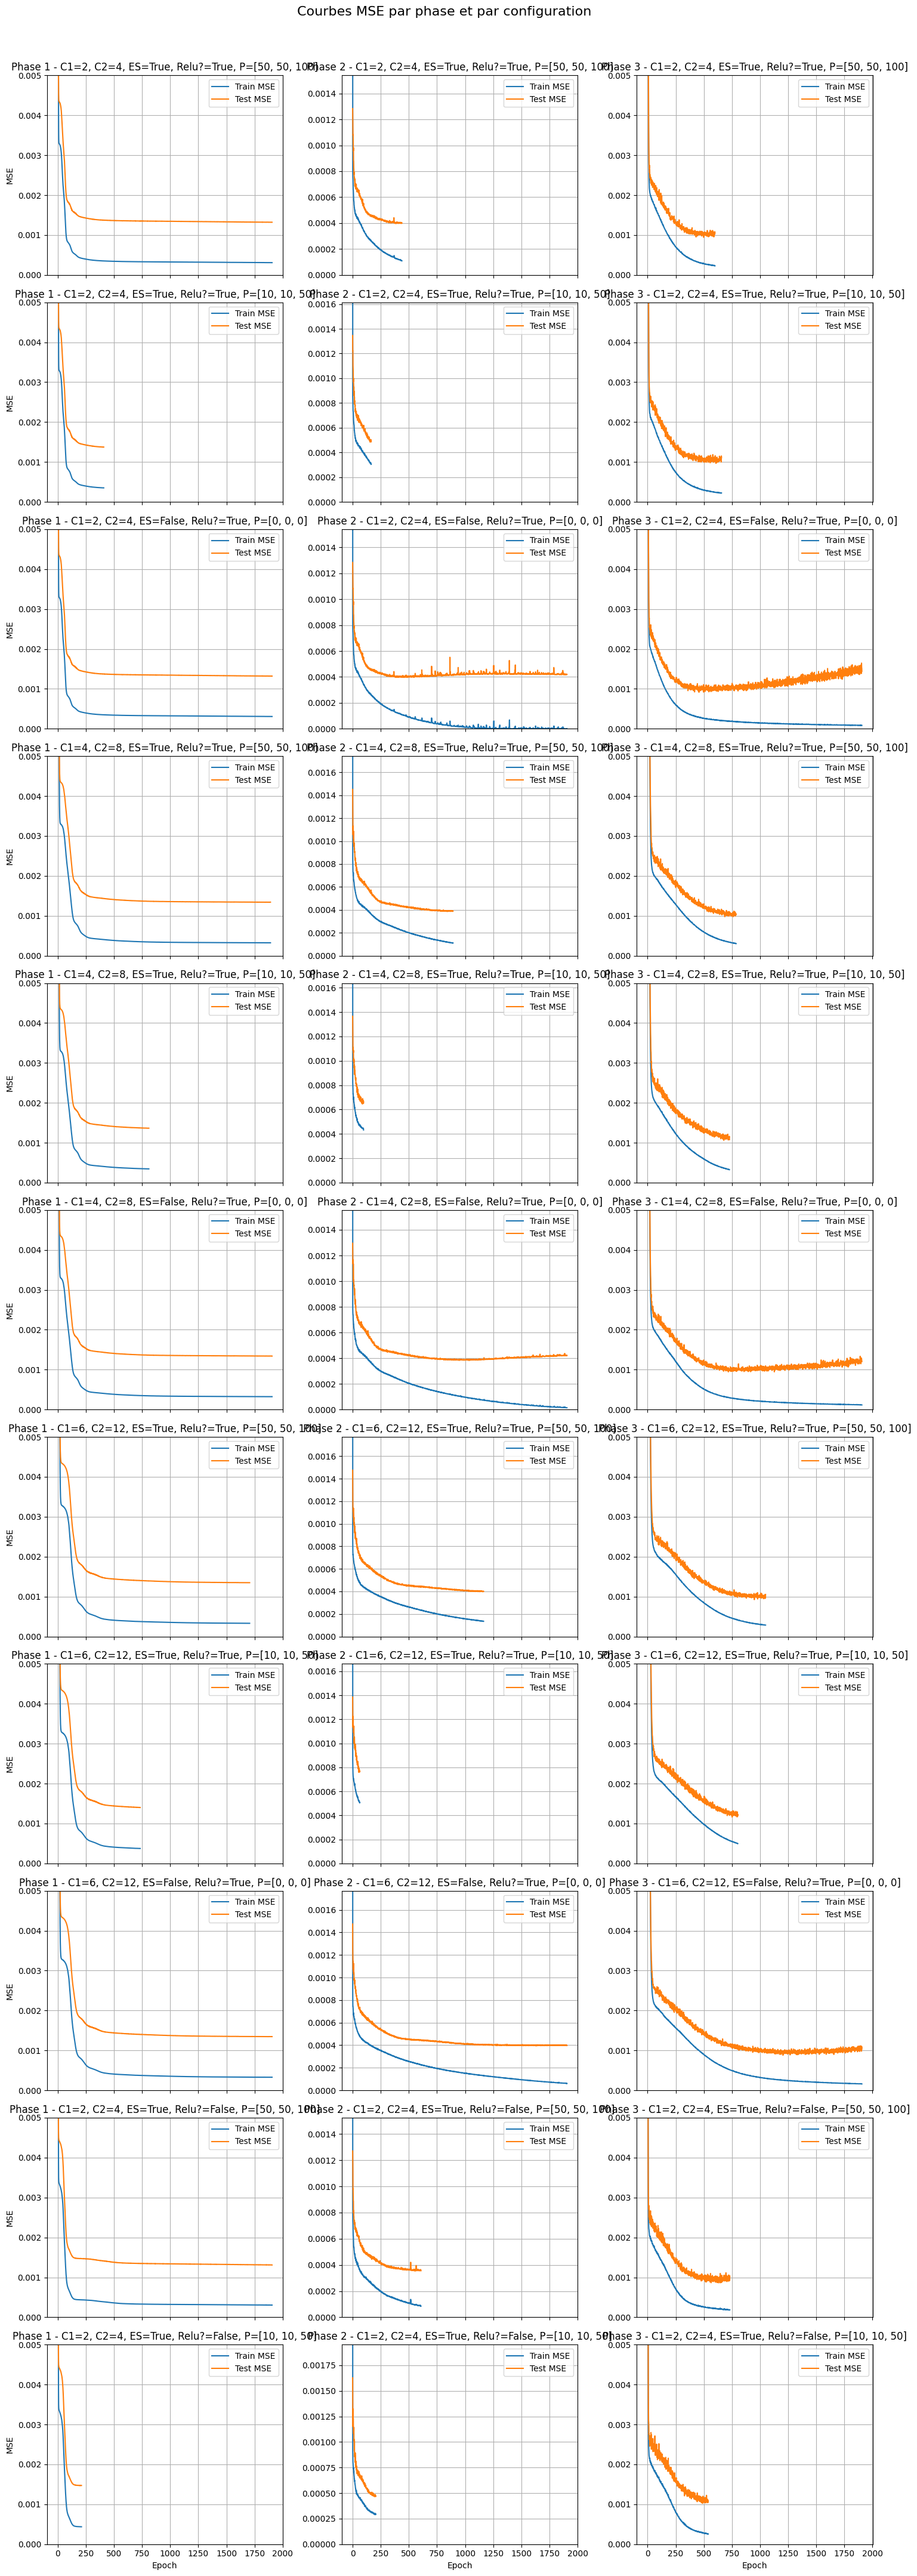

In [ ]:
n_experiments = len(experiments_data)
fig, axes = plt.subplots(nrows=n_experiments, ncols=3, figsize=(15, 4 * n_experiments), sharex=True)


for i, exp in enumerate(experiments_data):
    config = exp["config"]
    label = f'C1={config["compress1"]}, C2={config["compress2"]}, ES={config["earlystop"]}, Relu?={config["isRelu"]}, P={config["patience"]}'

    # Phase 1
    axes[i, 0].plot(exp["p1_train_mse"], label="Train MSE")
    axes[i, 0].plot(exp["p1_test_mse"], label="Test MSE")
    axes[i, 0].set_title(f'Phase 1 - {label}')
    axes[i, 0].set_ylabel("MSE")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Phase 2
    axes[i, 1].plot(exp["p2_train_mse"], label="Train MSE")
    axes[i, 1].plot(exp["p2_test_mse"], label="Test MSE")
    axes[i, 1].set_title(f'Phase 2 - {label}')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

    # Phase 3
    axes[i, 2].plot(exp["p3_train_mse"], label="Train MSE")
    axes[i, 2].plot(exp["p3_test_mse"], label="Test MSE")
    axes[i, 2].set_title(f'Phase 3 - {label}')
    axes[i, 2].legend()
    axes[i, 2].grid(True)

    # limit high
    axes[i, 0].set_ylim(0, 0.005)
    axes[i, 1].set_ylim(0, max(exp["p2_test_mse"]) * 1.2)
    axes[i, 2].set_ylim(0, 0.005)

for ax in axes[-1]:
    ax.set_xlabel("Epoch")

fig.suptitle("Courbes MSE par phase et par configuration", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("grid_mse_phases.png")
plt.show()


In [ ]:
summary_rows = []

for exp in experiments_data:
    config = exp["config"]
    row = {
        "compress1": config["compress1"],
        "compress2": config["compress2"],
        "patience": str(config["patience"]),
        "earlystop": config["earlystop"],
        "isRelu": config["isRelu"],
        "final_r2_p3": exp["p3_test_r2"][-1],
        "final_mse_p1": exp["p1_test_mse"][-1],
        "final_mse_p2": exp["p2_test_mse"][-1],
        "final_mse_p3": exp["p3_test_mse"][-1],
        "time": exp["time"]
    }
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)

df_summary.to_csv("results_summary.csv", index=False)

display(df_summary)

,compress1,compress2,patience,earlystop,isRelu,final_r2_p3,final_mse_p1,final_mse_p2,final_mse_p3,time
0,2,4,"[50, 50, 100]",True,True,0.987380,0.001321,0.000399,0.001048,482.17
1,2,4,"[10, 10, 50]",True,True,0.986708,0.001373,0.000486,0.001106,185.17
2,2,4,"[0, 0, 0]",False,True,0.982605,0.001321,0.000419,0.001441,933.09
3,4,8,"[50, 50, 100]",True,True,0.987422,0.001343,0.000390,0.001045,387.86
4,4,8,"[10, 10, 50]",True,True,0.987038,0.001365,0.000665,0.001078,171.80
5,4,8,"[0, 0, 0]",False,True,0.985552,0.001341,0.000421,0.001202,662.87
6,6,12,"[50, 50, 100]",True,True,0.987342,0.001349,0.000400,0.001053,372.70
7,6,12,"[10, 10, 50]",True,True,0.985304,0.001402,0.000766,0.001224,152.52
8,6,12,"[0, 0, 0]",False,True,0.986955,0.001347,0.000398,0.001082,554.05
9,2,4,"[50, 50, 100]",True,False,0.987562,0.001311,0.000356,0.001034,519.70


## Calculate the CCC scores for each model

In [ ]:
# New pseudo test set from same scRNA_test
xtest_new, ytest_new, _ = generate_synthethic(scRNA_test, nsamples=int(nsamples * test_size))

# Transform and normalize
xtest_new, _, _ = transform_and_normalize(xtest_new, xtest, bulkRNA.values)

# Convert to tensor
xtest_new = torch.tensor(xtest_new, dtype=torch.float32)

summary_rows = []

for i, exp in enumerate(experiments_data):
    config = exp["config"]

    # Rebuild model
    model = SweetWaterAutoEncoder(
        num_features=xtest_new.shape[1],
        num_classes=ytest_new.shape[1],
        compress_length1=config["compress1"],
        compress_length2=config["compress2"],
        isRelu=config["isRelu"]
    ).to(device)

    model.load_state_dict(exp["model"])
    model.eval()

    # Predict and compute CCC
    ypred = model(xtest_new.to(device), mode='phase3').detach().cpu().numpy()
    ccc = CCCscore(ypred, ytest_new)

    # Build summary row
    row = {
        "compress1": config["compress1"],
        "compress2": config["compress2"],
        "patience": str(config["patience"]),
        "earlystop": config["earlystop"],
        "isRelu": config["isRelu"],
        "ccc_score": ccc,
    }
    summary_rows.append(row)

# Create summary DataFrame
df_summary = pd.DataFrame(summary_rows)

# Optional: save to CSV
df_summary.to_csv("results_summary_with_ccc.csv", index=False)

# Display
display(df_summary)



simulating bulk: 100%|██████████| 1023/1023 [00:00<00:00, 1393.04it/s]


,compress1,compress2,patience,earlystop,isRelu,ccc_score
0,2,4,"[50, 50, 100]",True,True,0.993566
1,2,4,"[10, 10, 50]",True,True,0.993034
2,2,4,"[0, 0, 0]",False,True,0.990979
3,4,8,"[50, 50, 100]",True,True,0.993559
4,4,8,"[10, 10, 50]",True,True,0.993254
5,4,8,"[0, 0, 0]",False,True,0.992509
6,6,12,"[50, 50, 100]",True,True,0.993369
7,6,12,"[10, 10, 50]",True,True,0.992215
8,6,12,"[0, 0, 0]",False,True,0.993202
9,2,4,"[50, 50, 100]",True,False,0.993590


/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


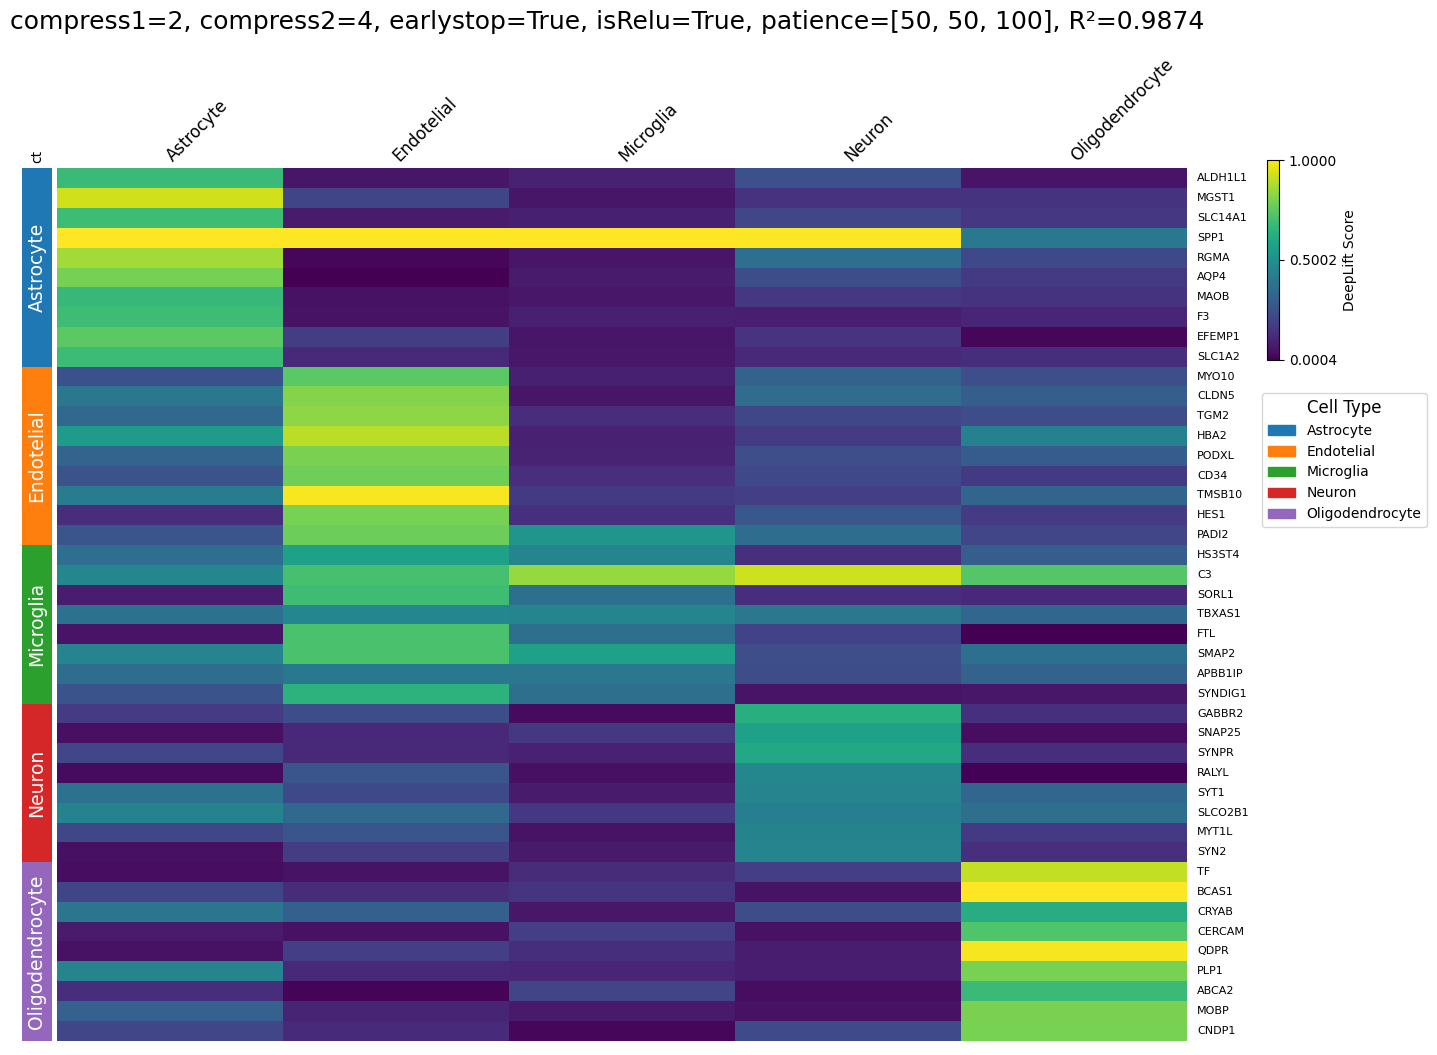

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


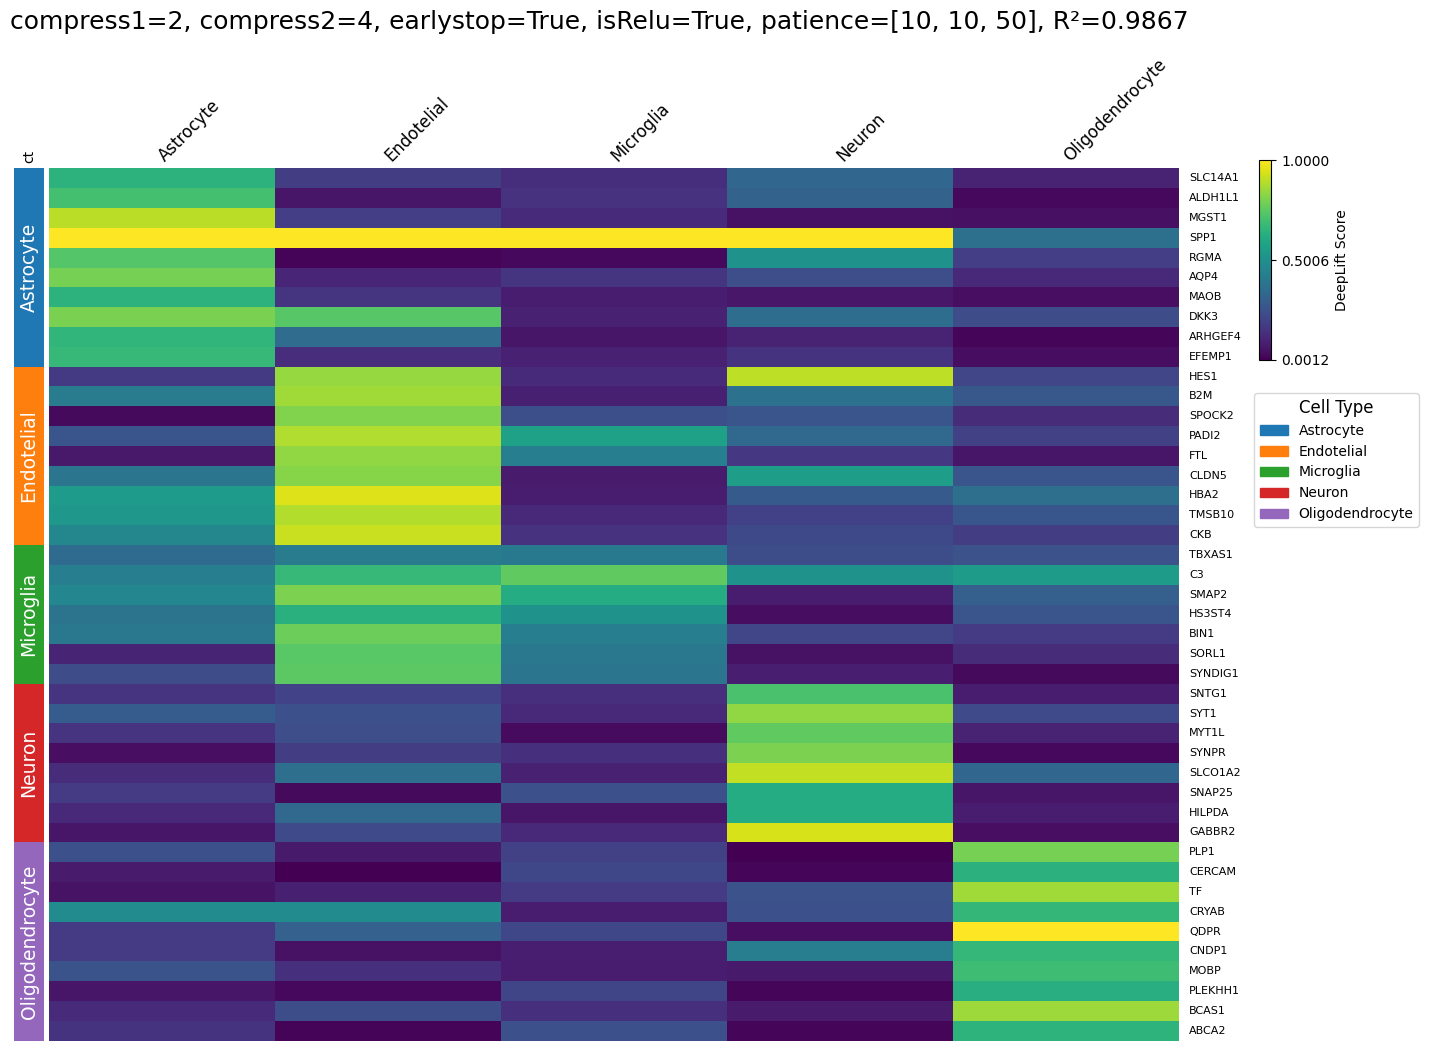

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


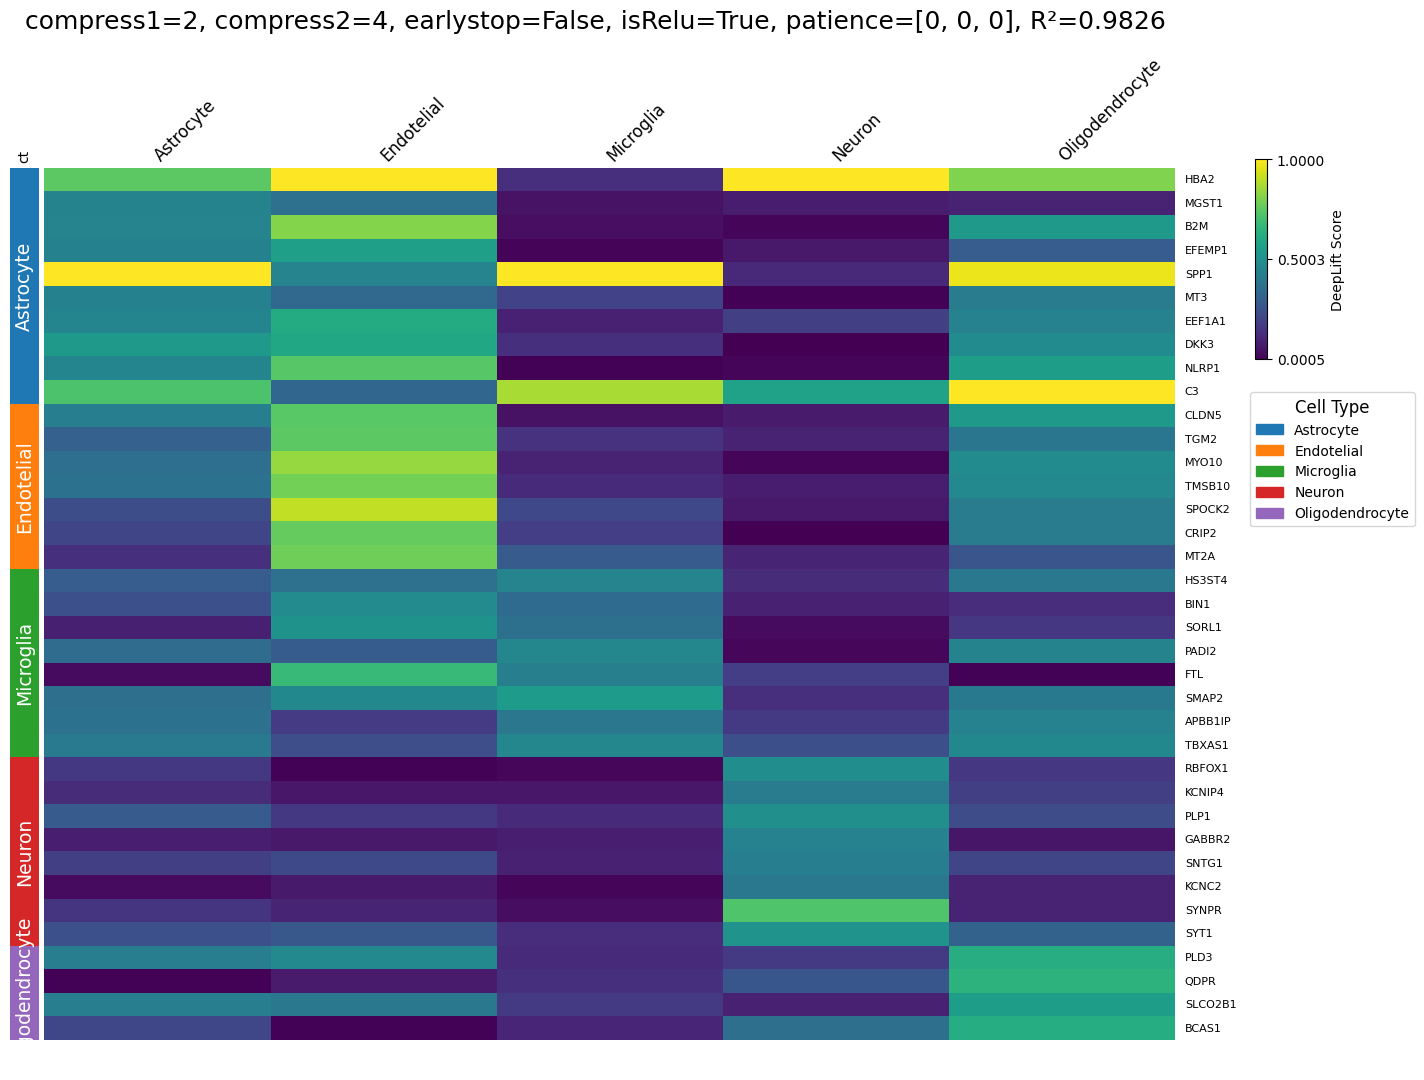

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


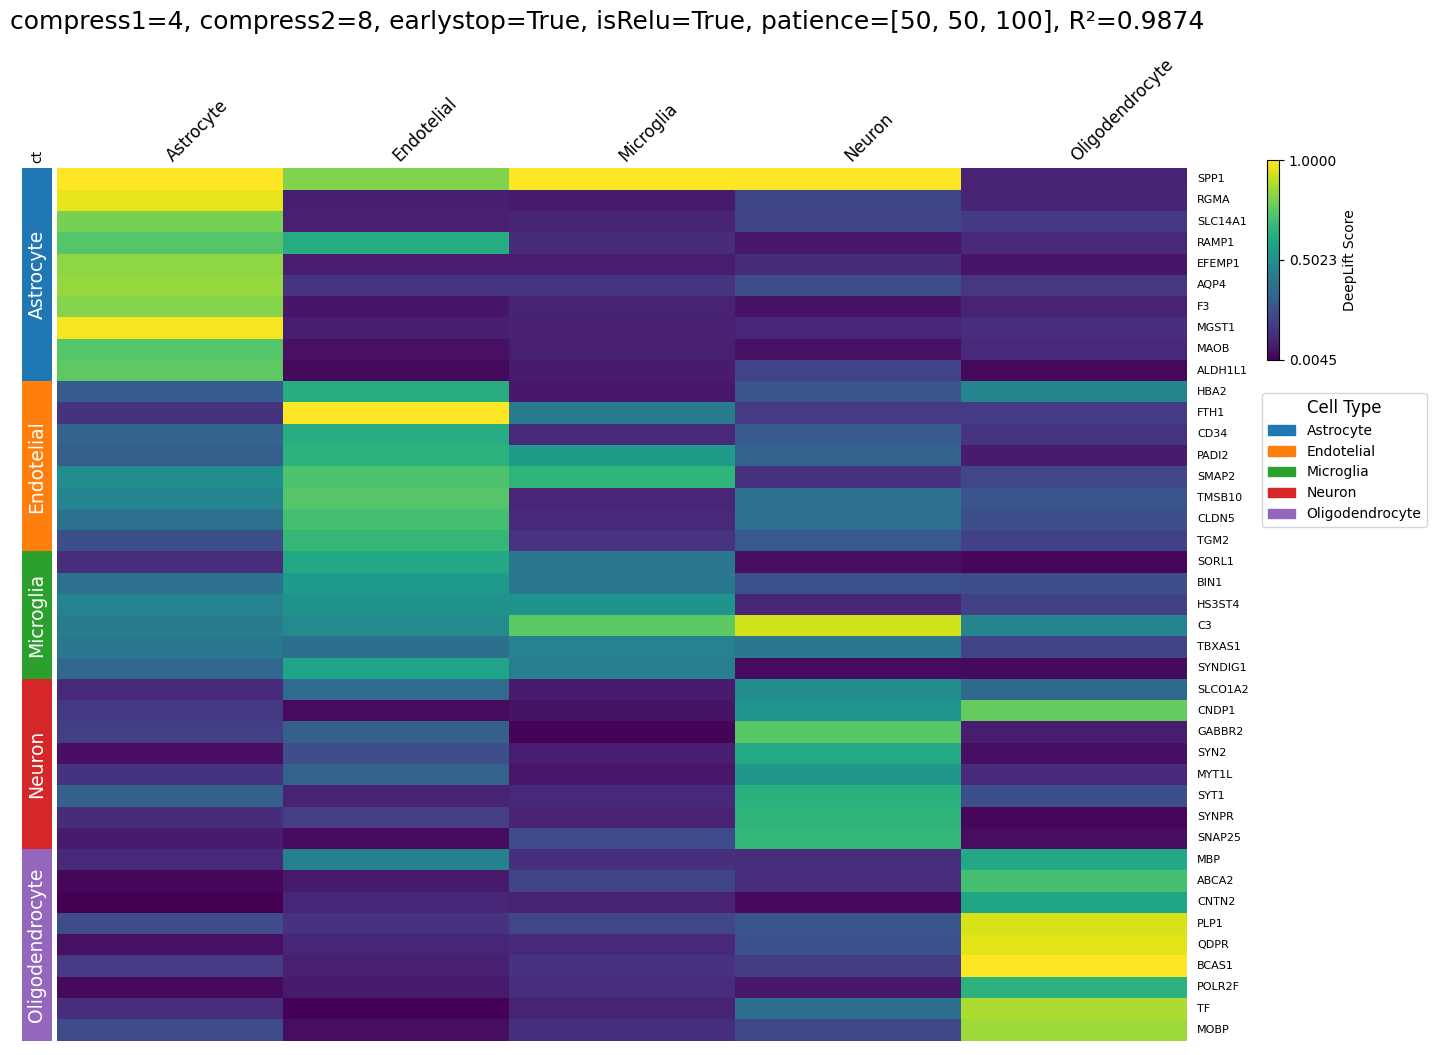

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


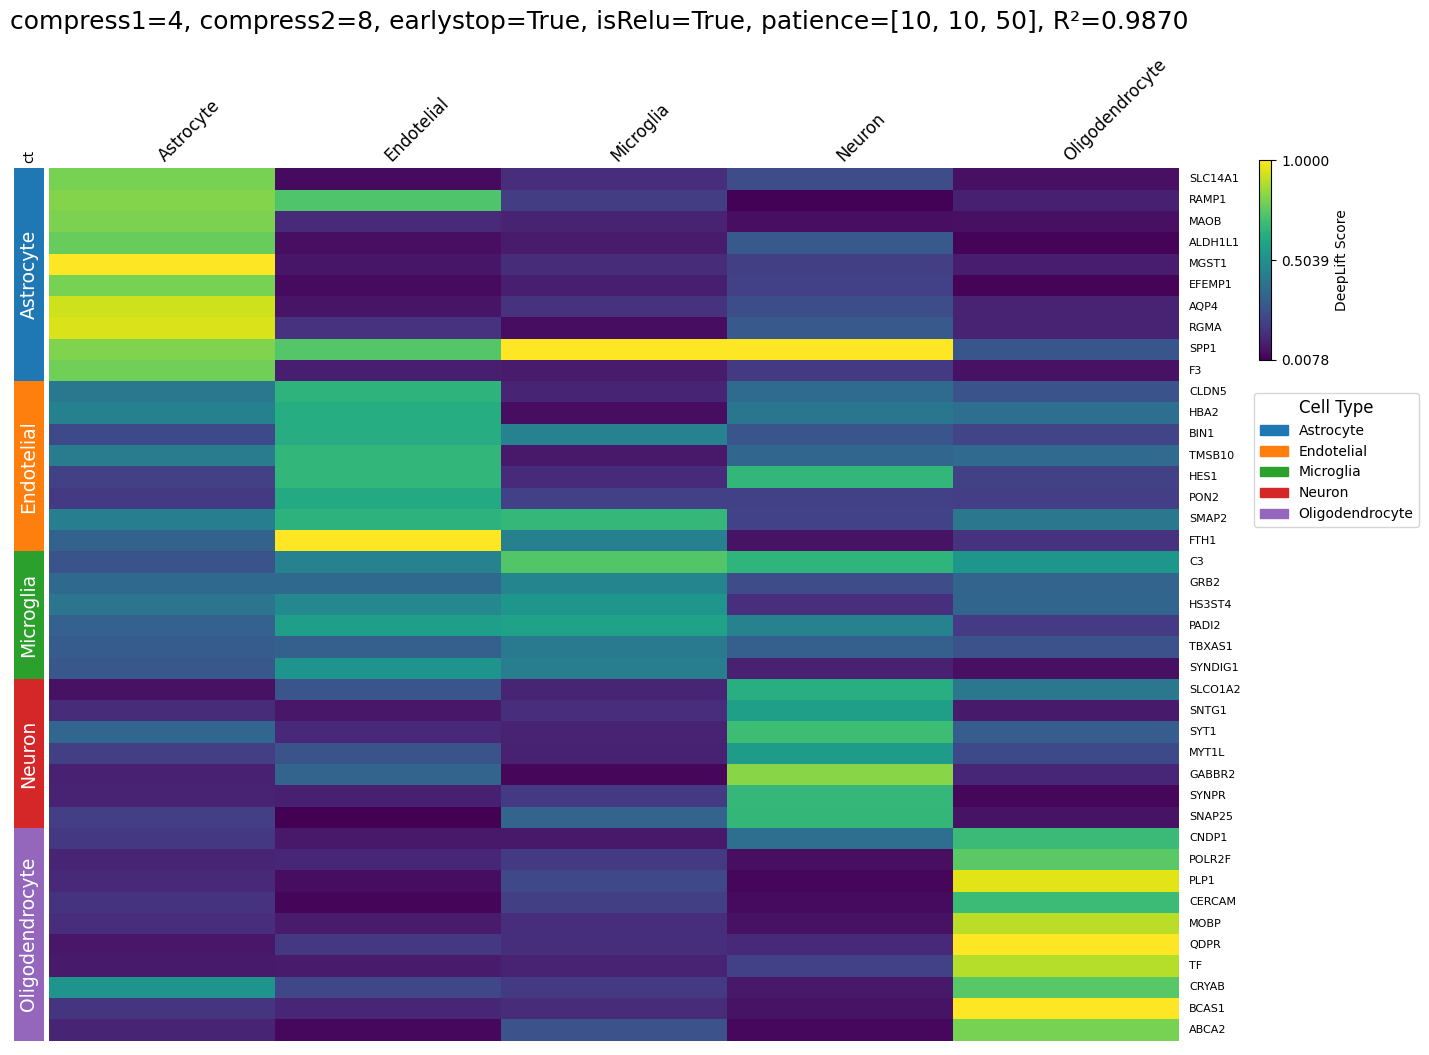

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


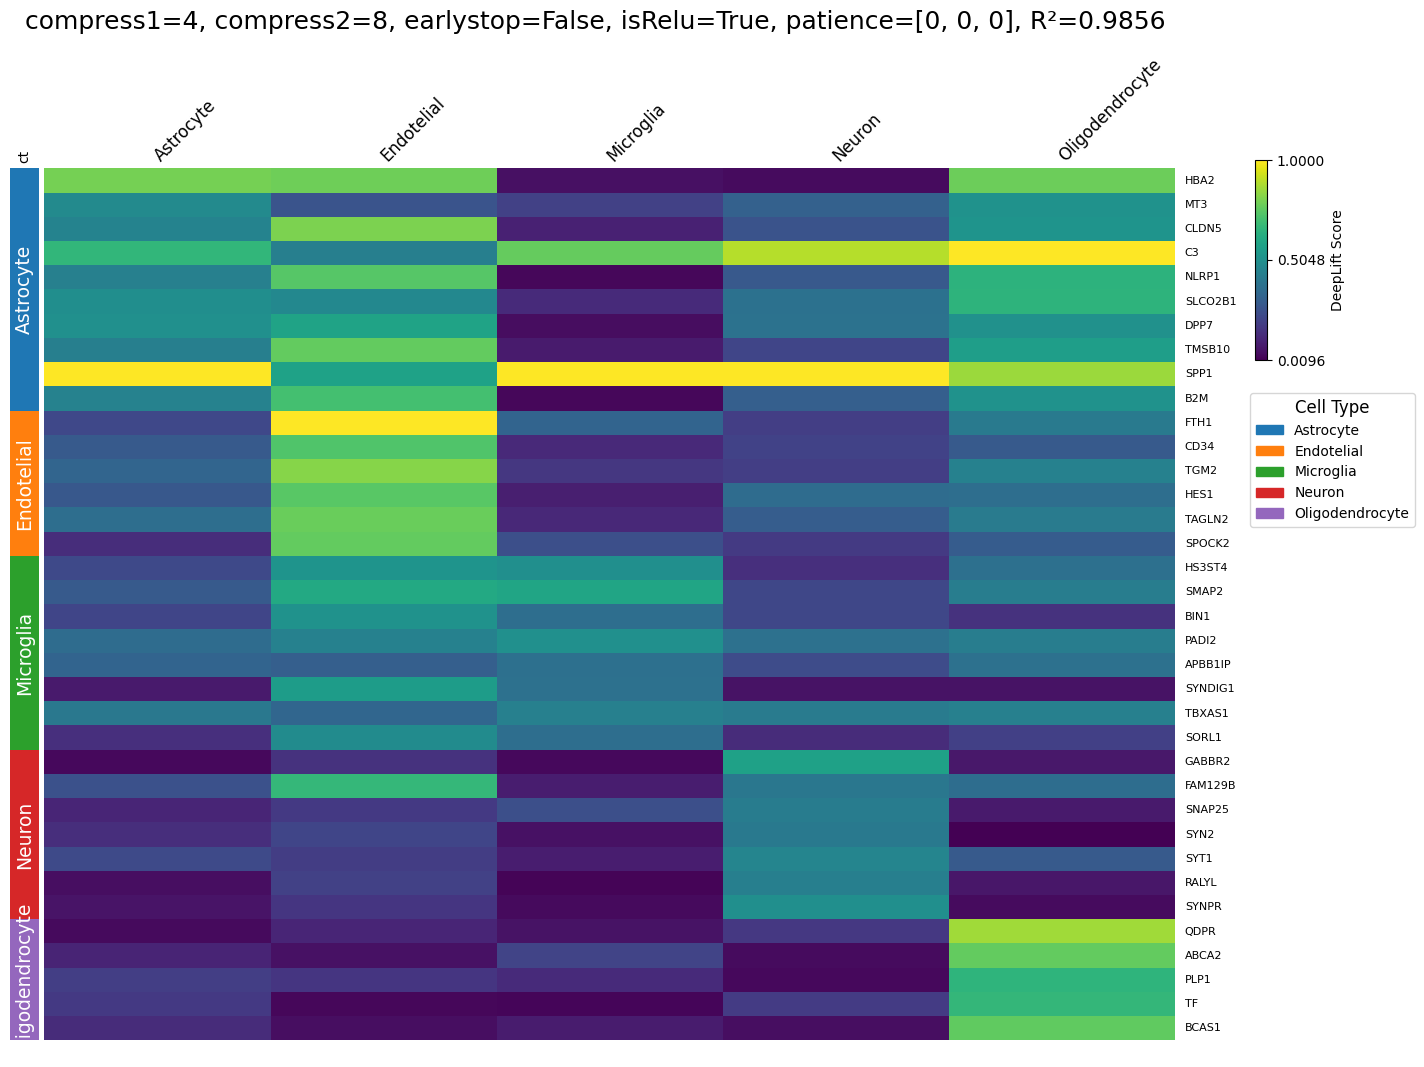

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


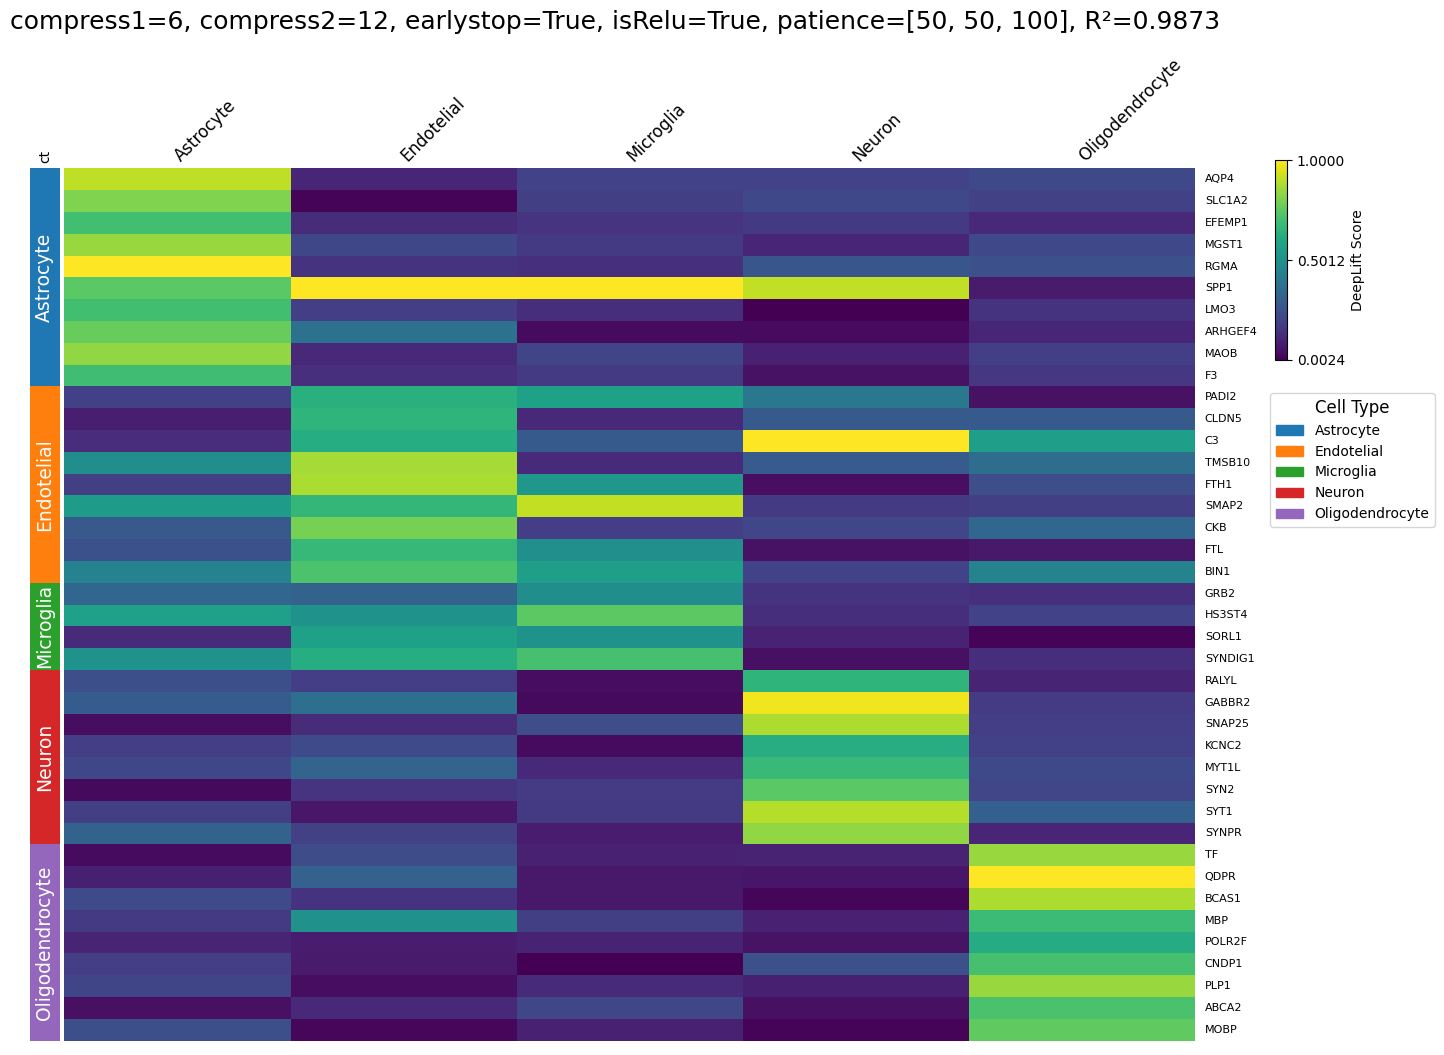

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


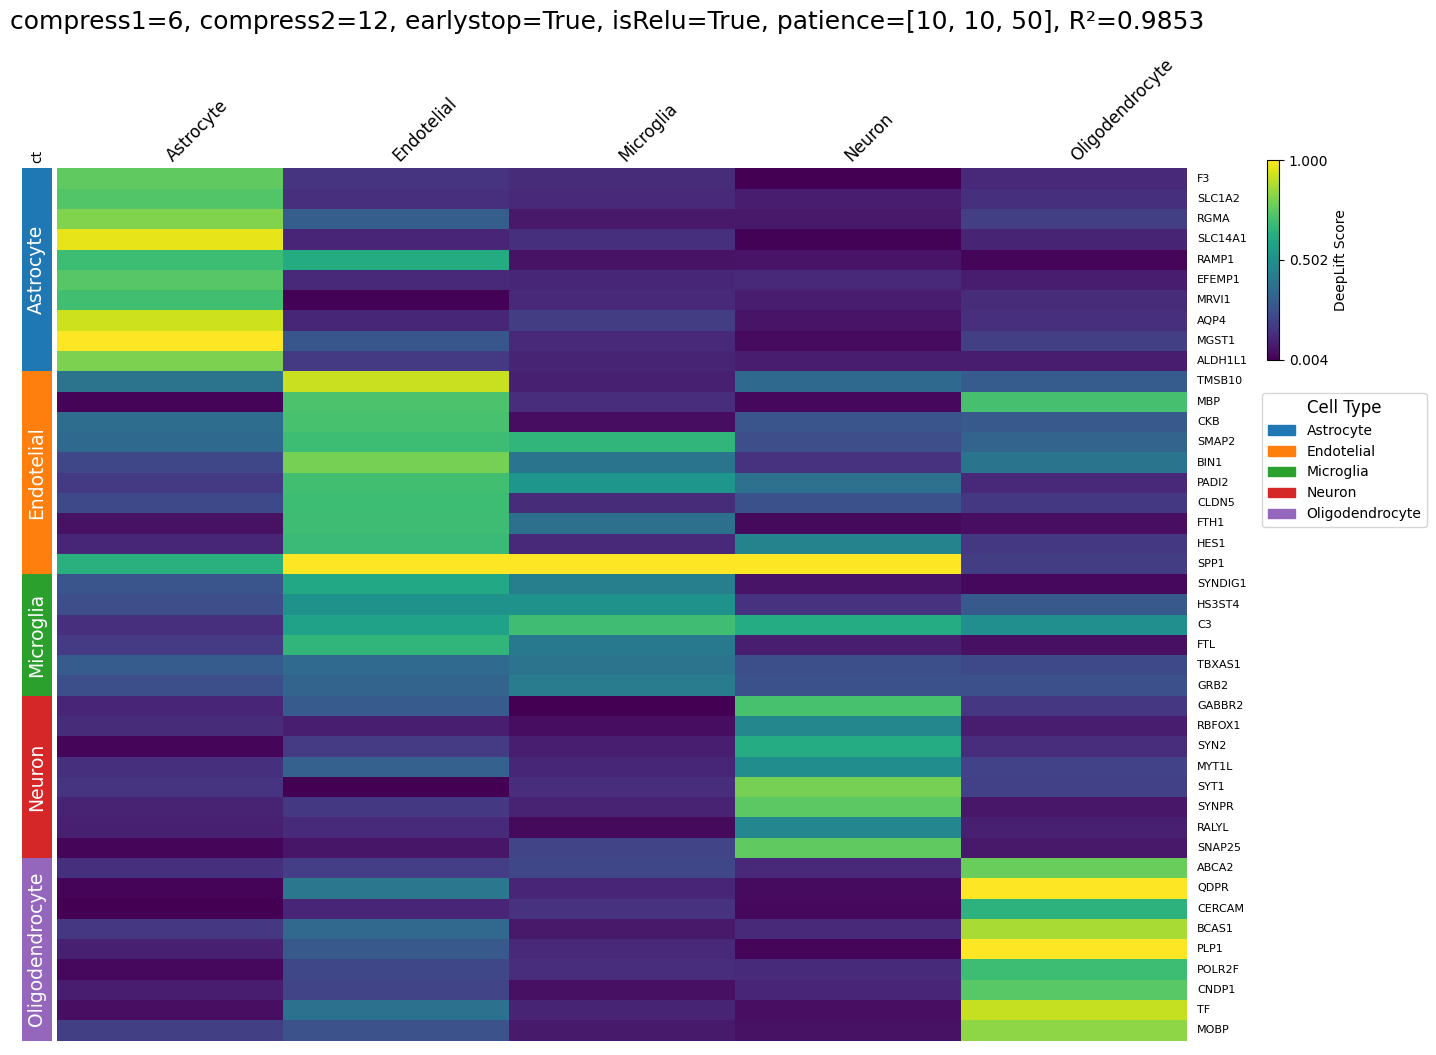

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


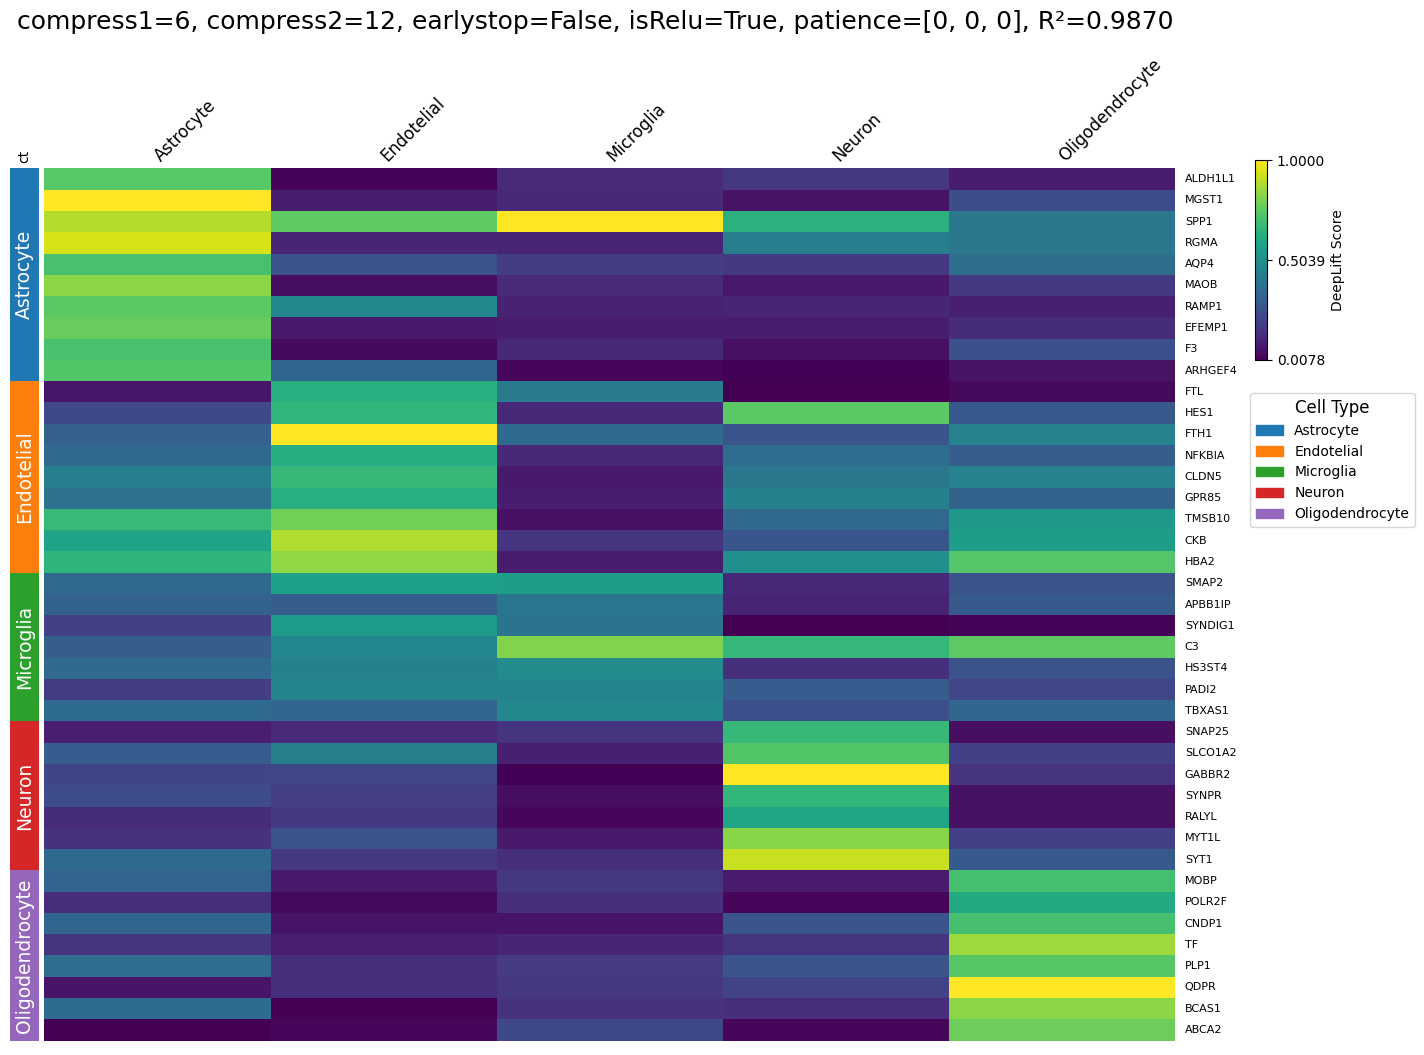

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


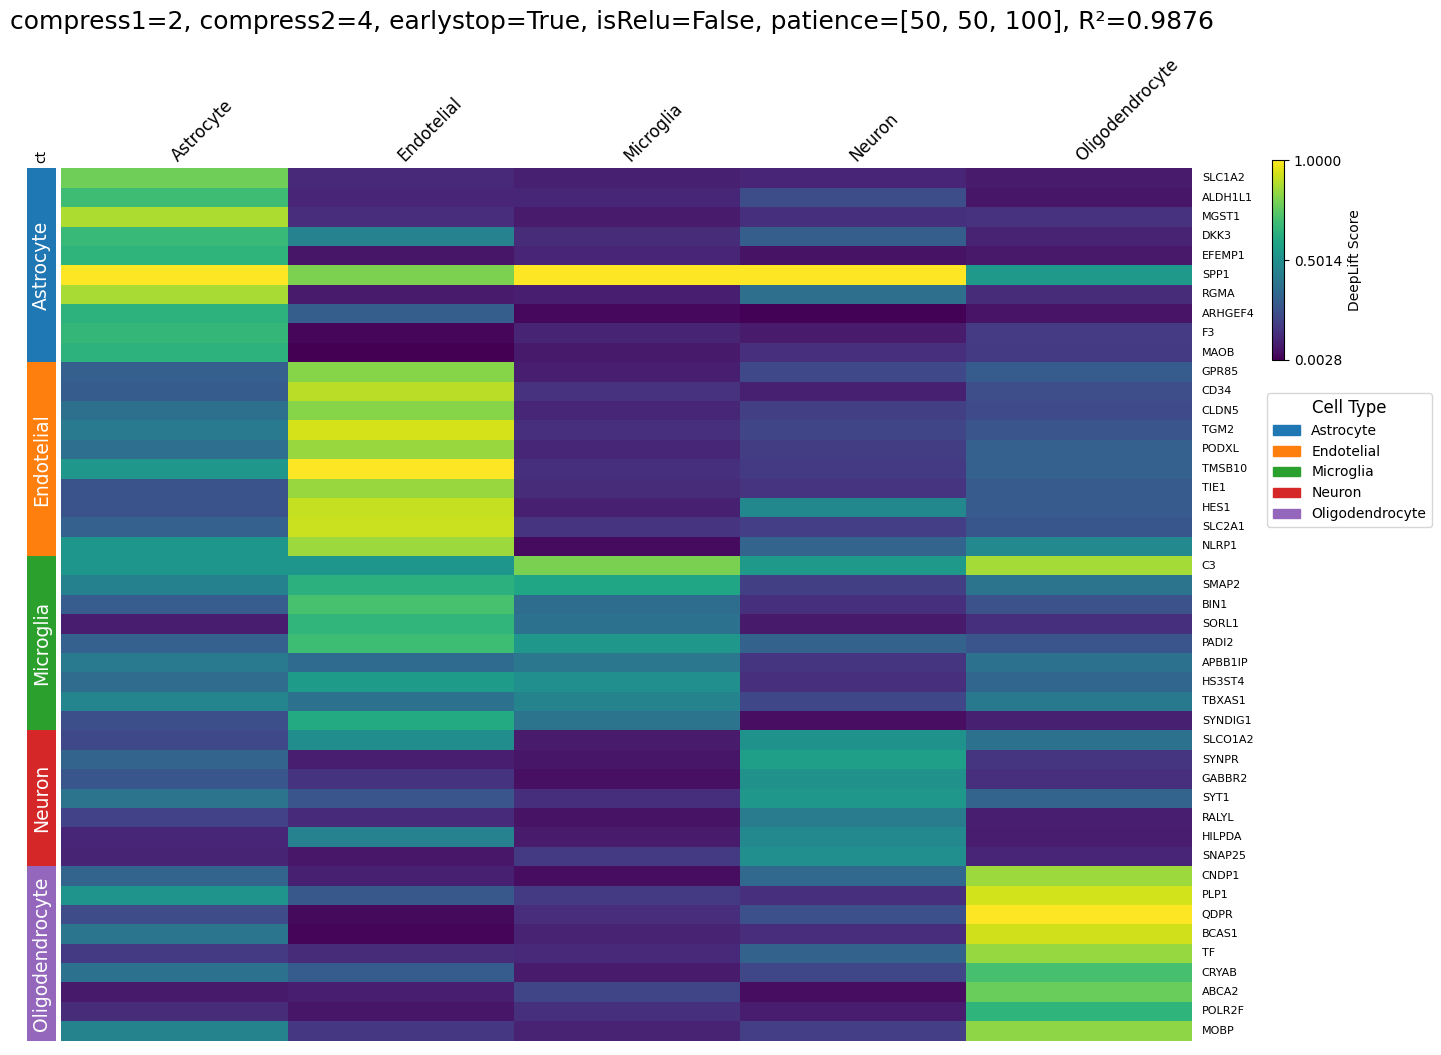

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


<ipython-input-4-ba29b938753a>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


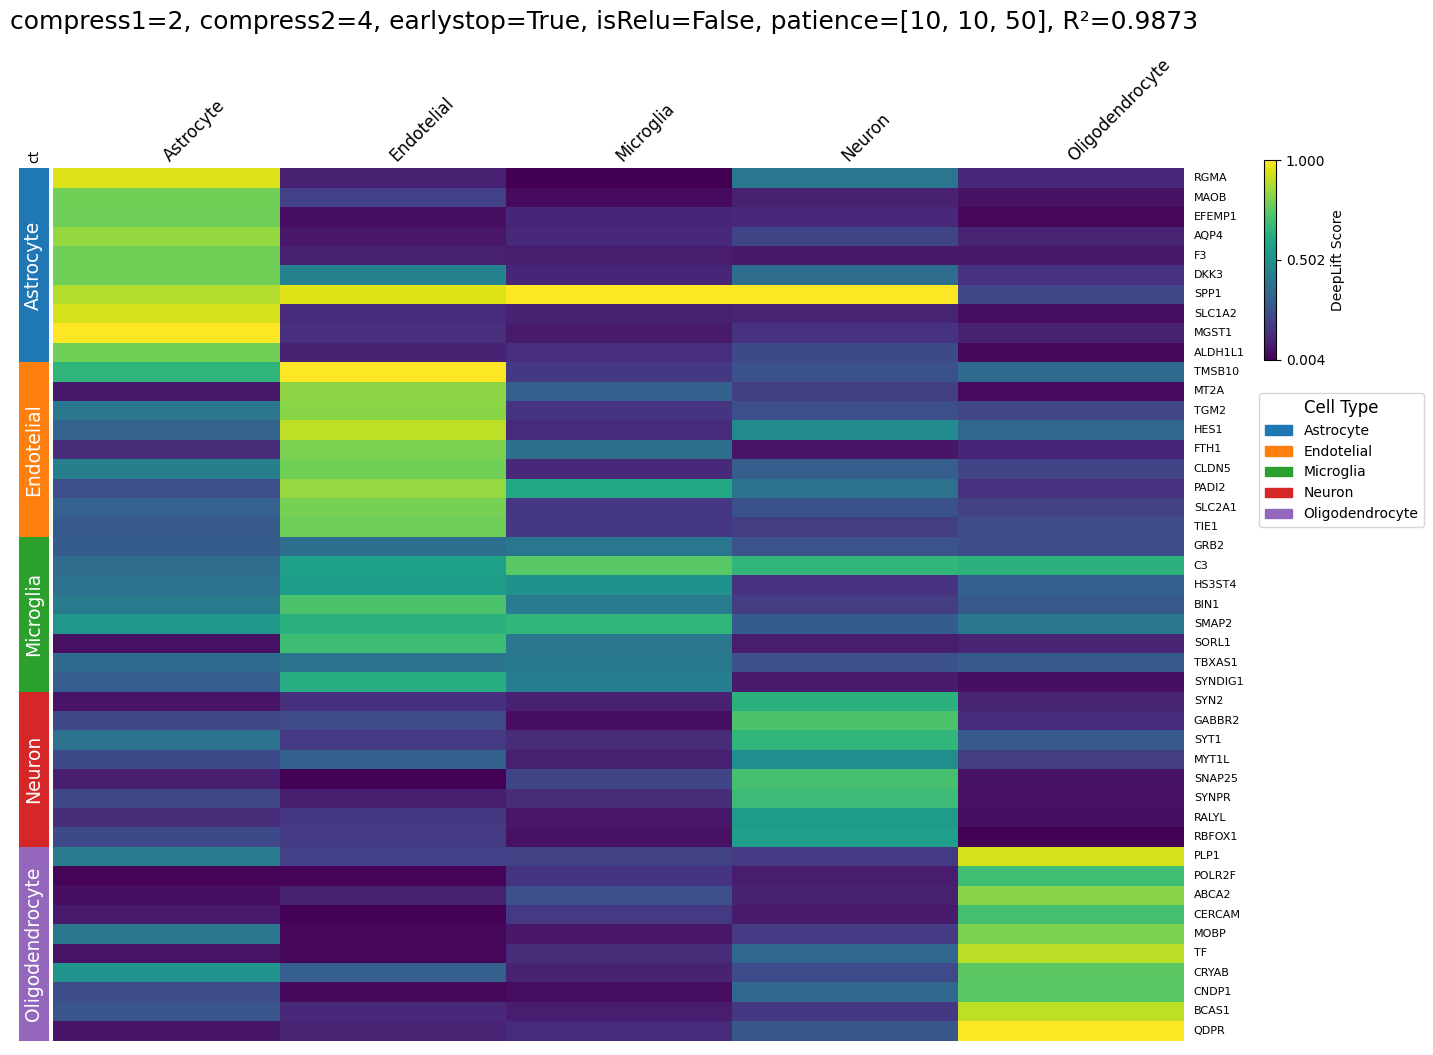

In [ ]:
for i, exp in enumerate(experiments_data):
    config = exp["config"]
    model = SweetWaterAutoEncoder(
        num_features=xtrain.shape[1],
        num_classes=ytrain.shape[1],
        compress_length1=config["compress1"],
        compress_length2=config["compress2"]
    ).to(device)

    model.load_state_dict(exp["model"])
    model.eval()

    x_input = xbulk.to(device).requires_grad_()
    deeplift = DeepLift(model)

    attr_dict = {}
    for j, ct in enumerate(celltypes):
        attr = deeplift.attribute(inputs=x_input, target=j)
        attr_dict[ct] = torch.mean(attr, dim=0).detach().cpu().numpy()

    df = pd.DataFrame(attr_dict, index=bulkRNA.columns).abs()

    top_k = 10
    top_genes = set()
    for col in df.columns:
        top_genes |= set(df[col].nlargest(top_k).index)

    filtered_df = df.loc[list(top_genes)]

    gene_celltype_map = []
    for ct in filtered_df.columns:
        top_genes_ct = filtered_df[ct].nlargest(top_k).index
        for gene in top_genes_ct:
            gene_celltype_map.append((gene, ct))

    marker_annot = pd.DataFrame(gene_celltype_map, columns=["gene", "celltype"]).drop_duplicates().set_index("gene")
    filtered_df = filtered_df[~filtered_df.index.duplicated(keep='first')]
    marker_annot = marker_annot.loc[marker_annot.index.isin(filtered_df.index)]
    marker_annot = marker_annot[~marker_annot.index.duplicated(keep='first')]
    marker_annot = marker_annot.loc[filtered_df.index]
    marker_annot = marker_annot.sort_values("celltype")
    filtered_df = filtered_df.loc[marker_annot.index]

    # === Plot and Save ===
    fig_path = f"heatmap_model_{i}_c1_{config['compress1']}_c2_{config['compress2']}_es_{config['earlystop']}_isRelu_{config['isRelu']}_{config['patience']}.png"
    title = f"compress1={config['compress1']}, compress2={config['compress2']}, earlystop={config['earlystop']}, isRelu={config['isRelu']}, patience={config['patience']}, R²={exp['final_r2']:.4f}"
    plot_complexheatmap(filtered_df, marker_annot, save_path=fig_path, title=title)
